# Compare GCHP and GCC NetCDF Diagnostics

## Overview of this Notebook

* Import dependencies
* Define data sources
* Explore GCC and GCHP data using xarray and numpy
* Define functions for regridding (lat/lon -> lat/lon, cubed sphere -> lat/lon)
* Create regridding weights
* Define function to make comparison plots for single vertical level global map
* Define function to make comparison plots for zonal mean
* Save GCC versus GCHP comparison plots to a pdf

## Import dependencies

In [1]:
import os
import numpy as np
import xarray as xr
import cubedsphere as cs
import xesmf as xe
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
from cartopy import crs
from cartopy.mpl.geoaxes import GeoAxes

%matplotlib inline
import warnings; warnings.filterwarnings("ignore")

# Also define colormap. Colormap file source: https://bitbucket.org/gcst/gcpy
rgb_WhGrYlRd = np.genfromtxt('../data/WhGrYlRd.txt',delimiter=' ')
WhGrYlRd = ListedColormap(rgb_WhGrYlRd/255.0)

## Define data sources

In [2]:
# High-level data directory
datadir = '/home/ubuntu/csci_e29/project/data'

# GCC subdirectory
f1datadir = 'gcc'

# GCHP subdirectory
f2datadir = 'gchp'

### Print data files for GCC and GCHP

In [3]:
GCC_files = [k for k in os.listdir(os.path.join(datadir,f1datadir)) if '.nc4' in k]
for k in GCC_files:
    print(k)

GEOSChem.ProdLoss.20160701_0000z.nc4
GEOSChem.ConcAfterChem.20160701_0000z.nc4
GEOSChem.DryDep.20160701_0000z.nc4
GEOSChem.WetLossConv.20160701_0000z.nc4
GEOSChem.JValuesLocalNoon.20160701_0000z.nc4
GEOSChem.Aerosols.20160701_0000z.nc4
GEOSChem.StateChm.20160701_0000z.nc4
GEOSChem.WetLossLS.20160701_0000z.nc4
GEOSChem.LevelEdgeDiags.20160701_0000z.nc4
GEOSChem.SpeciesConc.20160701_0000z.nc4
GEOSChem.JValues.20160701_0000z.nc4
GEOSChem.AerosolMass.20160701_0000z.nc4
GEOSChem.CloudConvFlux.20160701_0000z.nc4
GEOSChem.StateMet.20160701_0000z.nc4


In [4]:
GCHP_files = [k for k in os.listdir(os.path.join(datadir,f2datadir)) if '.nc4' in k]
for k in GCHP_files:
    print(k)

GCHP.WetLossConv.20160716_1200z.nc4
GCHP.ConcAfterChem.20160716_1200z.nc4
GCHP.Aerosols.20160716_1200z.nc4
GCHP.SpeciesConc.20160716_1200z.nc4
GCHP.JValues.20160716_1200z.nc4
GCHP.DryDep.20160716_1200z.nc4
GCHP.AerosolMass.20160716_1200z.nc4
GCHP.Emissions.20160716_1200z.nc4
GCHP.StateChm.20160716_1200z.nc4
GCHP.JValuesLocalNoon.20160716_1200z.nc4
GCHP.LevelEdgeDiags.20160716_1200z.nc4
GCHP.CloudConvFlux.20160716_1200z.nc4
GCHP.StateMet.20160716_1200z.nc4


### Define common filename for easy path generation, and write functions to get paths

In [5]:
# GCC
f1day = '20160701' # YYYYMMDD: start date of time-averaging period
f1time='0000'      # HHmm: GCC filename shows start time of time-averaging period

# GCHP
f2day = '20160716' # YYYYMMDD
f2time='1200'      # HHmm: GCHP filename shows mid-point time of time-averaging period

In [6]:
def get_gcc_filepath(datadir, modeldir, collection, day, time):
    if collection == 'Emissions':
        filepath = os.path.join(datadir, modeldir, 'HEMCO_diagnostics.{}{}.nc'.format(day,time))
    else:
        filepath = os.path.join(datadir, modeldir, 'GEOSChem.{}.{}_{}z.nc4'.format(collection,day,time))
    print('GCC data path: {}'.format(filepath))
    return filepath

def get_gchp_filepath(datadir, modeldir, collection, day, time):
    filepath = os.path.join(datadir, modeldir, 'GCHP.{}.{}_{}z.nc4'.format(collection,day,time))
    print('GCHP data path: {}'.format(filepath))
    return filepath

## Explore GCC and GCHP data using xarray

### Get file paths for one collection (set of diagnostics)

In [7]:
collection = 'SpeciesConc'
f1 = get_gcc_filepath(datadir, f1datadir, collection, f1day, f1time)
f2 = get_gchp_filepath(datadir, f2datadir, collection, f2day, f2time)

GCC data path: /home/ubuntu/csci_e29/project/data/gcc/GEOSChem.SpeciesConc.20160701_0000z.nc4
GCHP data path: /home/ubuntu/csci_e29/project/data/gchp/GCHP.SpeciesConc.20160716_1200z.nc4


### Inspect GCC xarray dataset

In [8]:
ds1 = xr.open_dataset(f1)
ds1

<xarray.Dataset>
Dimensions:               (ilev: 73, lat: 46, lev: 72, lon: 72, time: 1)
Coordinates:
  * time                  (time) datetime64[ns] 2016-07-16T12:00:00
  * lev                   (lev) float64 0.9925 0.9775 0.9625 0.9475 0.9325 ...
  * ilev                  (ilev) float64 1.0 0.985 0.97 0.955 0.94 0.925 ...
  * lat                   (lat) float64 -89.0 -86.0 -82.0 -78.0 -74.0 -70.0 ...
  * lon                   (lon) float64 -180.0 -175.0 -170.0 -165.0 -160.0 ...
Data variables:
    hyam                  (lev) float64 0.02402 3.321 9.864 16.37 22.85 ...
    hybm                  (lev) float64 0.9925 0.9742 0.9526 0.9311 0.9096 ...
    hyai                  (ilev) float64 0.0 0.04805 6.594 13.13 19.61 26.09 ...
    hybi                  (ilev) float64 1.0 0.985 0.9634 0.9419 0.9204 ...
    P0                    float64 1e+03
    AREA                  (lat, lon) float32 2160470800.0 2160470800.0 ...
    SpeciesConc_pFe       (time, lev, lat, lon) float64 8.805e-16 8.805

### Inspect GCHP xarray dataset

In [9]:
ds2 = xr.open_dataset(f2)
ds2

<xarray.Dataset>
Dimensions:               (lat: 288, lev: 72, lon: 48, time: 1)
Coordinates:
  * lon                   (lon) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 ...
  * lat                   (lat) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 ...
  * lev                   (lev) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 ...
  * time                  (time) datetime64[ns] 2016-07-16T12:00:00
Data variables:
    SpeciesConc_ACET      (time, lev, lat, lon) float64 1.485e-09 1.419e-09 ...
    SpeciesConc_ACTA      (time, lev, lat, lon) float64 2.67e-14 3.327e-14 ...
    SpeciesConc_AERI      (time, lev, lat, lon) float64 3.917e-13 4.042e-13 ...
    SpeciesConc_ALD2      (time, lev, lat, lon) float64 3.692e-10 3.787e-10 ...
    SpeciesConc_ALK4      (time, lev, lat, lon) float64 1.418e-09 9.4e-10 ...
    SpeciesConc_ASOA1     (time, lev, lat, lon) float64 1.923e-13 1.44e-13 ...
    SpeciesConc_ASOA2     (time, lev, lat, lon) float64 6.17e-14 3.816e-14 ...
    SpeciesConc_ASOA3     (

## Compare dataset content and statistics


### Define function to get lists of variables common to both datasets

In [10]:
def compare_varnames(dgcc, dgchp):
    
    # Find common variables in collection by generating lists and list overlap
    gchpvars = [k for k in dgchp.data_vars.keys()]
    gccvars= [k for k in dgcc.data_vars.keys()]
    commonvars = sorted(list(set(gchpvars).intersection(set(gccvars))))
    gcconly = [v for v in gccvars if v not in gchpvars]
    gchponly = [v for v in gchpvars if v not in gccvars]
    dimmismatch = [v for v in commonvars if dgcc[v].ndim != dgchp[v].ndim]
    commonvars2D = [v for v in commonvars if dgcc[v].ndim == 3]
    commonvars3D = [v for v in commonvars if dgcc[v].ndim == 4]
    
    # Print information on common and mismatching variables, as well as dimensions
    print('{} common variables ({} are 2-dim and {} are 3-dim)'.format(len(commonvars), len(commonvars2D), len(commonvars3D)))
    if len(gcconly) > 0:
        print('{} variables in gcc only (skip)'.format(len(gcconly)))
        print('   Variable names: {}'.format(gcconly))
    if len(gchponly) > 0:
        print('{} variables in gchp only (skip)'.format(len(gchponly)))
        print('   Variable names: {}'.format(gchponly))
    if len(dimmismatch) > 0:
        print('{} common variables have different dimensions'.format(len(dimmismatch)))
        print('   Variable names: {}'.format(dimmismatch))
        
    return [commonvars, commonvars2D, commonvars3D]

### Get common variables for this collection

In [11]:
[commonvars, commonvars2D, commonvars3D] = compare_varnames(ds1, ds2)
print('Common variables: {}'.format(commonvars))

183 common variables (0 are 2-dim and 183 are 3-dim)
6 variables in gcc only (skip)
   Variable names: ['hyam', 'hybm', 'hyai', 'hybi', 'P0', 'AREA']
Common variables: ['SpeciesConc_ACET', 'SpeciesConc_ACTA', 'SpeciesConc_AERI', 'SpeciesConc_ALD2', 'SpeciesConc_ALK4', 'SpeciesConc_ASOA1', 'SpeciesConc_ASOA2', 'SpeciesConc_ASOA3', 'SpeciesConc_ASOAN', 'SpeciesConc_ASOG1', 'SpeciesConc_ASOG2', 'SpeciesConc_ASOG3', 'SpeciesConc_BCPI', 'SpeciesConc_BCPO', 'SpeciesConc_BENZ', 'SpeciesConc_Br', 'SpeciesConc_Br2', 'SpeciesConc_BrCl', 'SpeciesConc_BrNO2', 'SpeciesConc_BrNO3', 'SpeciesConc_BrO', 'SpeciesConc_BrSALA', 'SpeciesConc_BrSALC', 'SpeciesConc_C2H6', 'SpeciesConc_C3H8', 'SpeciesConc_CCl4', 'SpeciesConc_CFC11', 'SpeciesConc_CFC113', 'SpeciesConc_CFC114', 'SpeciesConc_CFC115', 'SpeciesConc_CFC12', 'SpeciesConc_CH2Br2', 'SpeciesConc_CH2Cl2', 'SpeciesConc_CH2I2', 'SpeciesConc_CH2IBr', 'SpeciesConc_CH2ICl', 'SpeciesConc_CH2O', 'SpeciesConc_CH3Br', 'SpeciesConc_CH3CCl3', 'SpeciesConc_CH3Cl', 

### Look at one variable more closely

In [12]:
varname='SpeciesConc_O3'
ds1_data = ds1[varname]
ds2_data = ds2[varname]
print('Variable array type: {}'.format(type(ds1_data)))
print('Variable values array type: {}'.format(type(ds1_data.values)))

Variable array type: <class 'xarray.core.dataarray.DataArray'>
Variable values array type: <class 'numpy.ndarray'>


### Explore the data values array using numpy. Here is just a very small sampling of the possibilities.

In [13]:
print('Array shape: GCC - {}, GCHP - {}'.format(ds1_data.shape, ds2_data.shape))
print('GCC mean concentration: {}'.format(ds1_data.values.mean()))
print('GCHP mean concentration: {}'.format(ds2_data.values.mean()))

Array shape: GCC - (1, 72, 46, 72), GCHP - (1, 72, 288, 48)
GCC mean concentration: 1.7005350483806303e-06
GCHP mean concentration: 2.071152858802602e-06


## Define functions for regridding

These functions utilize the xESMF package and the cubedsphere package developed by Jaiwei Zhuang, a graduate student at Harvard University. More specifically I use the cubedsphere package CSGrid class and the xESMF package Regridder class. The latter serves as a wrapper for the ESMF/ESMPy packages. These tools enable simple conservative regridding between lat/lon and cubed sphere horizontal grids as specifically defined by the NASA Global Modeling and Assimilation Office (GMAO). See http://xesmf.readthedocs.io/en/latest/ and https://github.com/JiaweiZhuang/cubedsphere for more information. 

### Function to make lat/lon half-polar grid (native horizontal grid for GCC)

In [14]:
def make_grid_LL(llres):
    [dlat,dlon] = list(map(float, llres.split('x')))
    lon_b = np.linspace(-180 - dlon/2, 180 - dlon/2, int(360/dlon) + 1, endpoint=True)
    lat_b = np.linspace(-90 - dlat/2, 90 + dlat/2, int(180/dlat) + 2, endpoint=True).clip(-90,90)
    lat = (lat_b[1:] + lat_b[:-1]) / 2
    lon = (lon_b[1:] + lon_b[:-1]) / 2
    llgrid = {'lat': lat, 
              'lon': lon, 
              'lat_b': lat_b, 
              'lon_b': lon_b}
    return llgrid

### Function to make GMAO cubed sphere grid (native horizontal grid for GCHP)

In [15]:
def make_grid_CS(csres):
    csgrid = cs.csgrid_GMAO(csres)
    csgrid_list = [None]*6
    for i in range(6):
        csgrid_list[i] = {'lat': csgrid['lat'][i], 
                          'lon': csgrid['lon'][i],
                          'lat_b': csgrid['lat_b'][i], 
                          'lon_b': csgrid['lon_b'][i]}
    return [csgrid, csgrid_list]

### Function to create a regridder object for regridding GCHP cubed sphere to GCC lat/long

In [16]:
def make_regridder_C2L( csres_in, llres_out, weightsdir='.', reuse_weights=False,  ):
    csgrid, csgrid_list = make_grid_CS(csres_in)
    llgrid = make_grid_LL(llres_out)
    regridder_list = []
    for i in range(6):
        weightsfile = os.path.join(weightsdir, 'conservative_c{}_{}_{}.nc'.format(str(csres_in), llres_out, str(i)))
        regridder = xe.Regridder(csgrid_list[i], llgrid, method='conservative', filename=weightsfile, reuse_weights=reuse_weights)
        regridder_list.append(regridder)
    return regridder_list

### Function to create a regridder object for regridding between different resolution GCC lat/lon grids

In [17]:
def make_regridder_L2L( llres_in, llres_out, weightsdir='.', reuse_weights=False ):
    llgrid_in = make_grid_LL(llres_in)
    llgrid_out = make_grid_LL(llres_out)
    weightsfile = os.path.join(weightsdir,'conservative_{}_{}.nc'.format(llres_in, llres_out))
    regridder = xe.Regridder(llgrid_in, llgrid_out, method='conservative', filename=weightsfile, reuse_weights=reuse_weights)
    return regridder

### Make a grid for a 4 degree lat x 5 deg lon grid and inspect output

Note: This is the resolution and grid of my GCC data.

In [18]:
llgrid = make_grid_LL('4x5')
print([[k, llgrid[k].shape] for k in llgrid.keys()])
print('lat:\n {}'.format(llgrid['lat']))
print('lat_b:\n {}'.format(llgrid['lat_b']))
print('lon:\n {}'.format(llgrid['lon']))
print('lon_b:\n {}'.format(llgrid['lon_b']))

[['lat', (46,)], ['lon', (72,)], ['lat_b', (47,)], ['lon_b', (73,)]]
lat:
 [-89. -86. -82. -78. -74. -70. -66. -62. -58. -54. -50. -46. -42. -38.
 -34. -30. -26. -22. -18. -14. -10.  -6.  -2.   2.   6.  10.  14.  18.
  22.  26.  30.  34.  38.  42.  46.  50.  54.  58.  62.  66.  70.  74.
  78.  82.  86.  89.]
lat_b:
 [-90. -88. -84. -80. -76. -72. -68. -64. -60. -56. -52. -48. -44. -40.
 -36. -32. -28. -24. -20. -16. -12.  -8.  -4.   0.   4.   8.  12.  16.
  20.  24.  28.  32.  36.  40.  44.  48.  52.  56.  60.  64.  68.  72.
  76.  80.  84.  88.  90.]
lon:
 [-180. -175. -170. -165. -160. -155. -150. -145. -140. -135. -130. -125.
 -120. -115. -110. -105. -100.  -95.  -90.  -85.  -80.  -75.  -70.  -65.
  -60.  -55.  -50.  -45.  -40.  -35.  -30.  -25.  -20.  -15.  -10.   -5.
    0.    5.   10.   15.   20.   25.   30.   35.   40.   45.   50.   55.
   60.   65.   70.   75.   80.   85.   90.   95.  100.  105.  110.  115.
  120.  125.  130.  135.  140.  145.  150.  155.  160.  165.  170.  175

### Make a grid for a six-faced cubed sphere grid with 48 cells per face side

Note: This is the resolution and grid of my GCHP data.

In [19]:
csgrid, csgrid_list = make_grid_CS(48)
[[k, csgrid[k].shape] for k in csgrid.keys()]
for i in range(6):
    print([[k,csgrid_list[i][k].shape] for k in csgrid_list[i].keys()]) 

[['lat', (48, 48)], ['lon', (48, 48)], ['lat_b', (49, 49)], ['lon_b', (49, 49)]]
[['lat', (48, 48)], ['lon', (48, 48)], ['lat_b', (49, 49)], ['lon_b', (49, 49)]]
[['lat', (48, 48)], ['lon', (48, 48)], ['lat_b', (49, 49)], ['lon_b', (49, 49)]]
[['lat', (48, 48)], ['lon', (48, 48)], ['lat_b', (49, 49)], ['lon_b', (49, 49)]]
[['lat', (48, 48)], ['lon', (48, 48)], ['lat_b', (49, 49)], ['lon_b', (49, 49)]]
[['lat', (48, 48)], ['lon', (48, 48)], ['lat_b', (49, 49)], ['lon_b', (49, 49)]]


## Create regridding weights for data native resolutions (only needs to be done once)

The xESMF Regridder object can create weights for regridding from one grid resolution to another, or it can be provided weights that are pre-generated to save time. Generating weights therefore only needs to be done once for each combination of input and output grid type and resolution. This can be done by calling the make_regridder functions and passing reuse_weights=False.

In [20]:
weightsdir = '.'
# This example notebook will regrid from cubed sphere 48 and lat/lon 4x5 to lat/lon 1x1.25.
regridder_C2L_list = make_regridder_C2L(48, '1x1.25', weightsdir=weightsdir, reuse_weights=False)
regridder_L2L = make_regridder_L2L('4x5', '1x1.25', weightsdir=weightsdir, reuse_weights=False)

Overwrite existing file: ./conservative_c48_1x1.25_0.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: ./conservative_c48_1x1.25_1.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: ./conservative_c48_1x1.25_2.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: ./conservative_c48_1x1.25_3.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: ./conservative_c48_1x1.25_4.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: ./conservative_c48_1x1.25_5.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: ./conservative_4x5_1x1.25.nc 
 You can set reuse_weights=True to save computing time.


## Define function to plot and compare single vertical level of GCHP and GCC

Note: This function regrids both GCC and GCHP on-the-fly using the pre-generated weights.

In [21]:
def compare_level_maps(dgcc, dgchp, varlist=None, weightsdir='.', ilev=0, itime=0, llres_raw='4x5', 
                        llres_cmp='1x1.25', savepdf=False, pdfname='gchp_vs_gcc_map.pdf', 
                        match_cbar=True, full_ratio_range=False, normalize_by_area=False, area1=None, area2=None):
    
    # If no varlist is passed, plot all (surface only for 3D)
    if varlist == None:
        [varlist, commonvars2D, commonvars3D] = compare_varnames(dgcc, dgchp)
        print('Plotting all common variables (surface only if 3D)')
    n_var = len(varlist)
    
    # Get lat-lon grids and regridder. Assume regridding weights have already been generated
    llgrid_raw = make_grid_LL(llres_raw)
    llgrid_cmp = make_grid_LL(llres_cmp)
    ll_regridder = make_regridder_L2L(llres_raw, llres_cmp, weightsdir=weightsdir, reuse_weights=True)

    # Get cubed sphere grid and regridder
    csres = dgchp['lon'].size
    [csgrid, csgrid_list] = make_grid_CS(csres)
    cs_regridder_list = make_regridder_C2L(csres, llres_cmp, weightsdir=weightsdir, reuse_weights=True)

    # Get lat/lon extents
    [minlon_raw, maxlon_raw] = [min(llgrid_raw['lon_b']), max(llgrid_raw['lon_b'])]
    [minlat_raw, maxlat_raw] = [min(llgrid_raw['lat_b']), max(llgrid_raw['lat_b'])]
    [minlon_cmp, maxlon_cmp] = [min(llgrid_cmp['lon_b']), max(llgrid_cmp['lon_b'])]
    [minlat_cmp, maxlat_cmp] = [min(llgrid_cmp['lat_b']), max(llgrid_cmp['lat_b'])]

    # Create pdf (if saving)
    if savepdf:
        print('\nCreating {}'.format(pdfname))
        pdf = PdfPages(pdfname)

    # Loop over variables
    for ivar in range(n_var):
        if savepdf: print('{} '.format(ivar), end='')
        varname = varlist[ivar]
        
        # Do some checks: dimensions and units
        varndim = dgchp[varname].ndim
        varndim2 = dgcc[varname].ndim
        assert varndim == varndim2, 'GCHP and GCC dimensions do not agree for {}!'.format(varname)
        units_raw = dgchp[varname].units
        units2 = dgcc[varname].units
        assert units_raw == units2, 'GCHP and GCC units do not match for {}!'.format(varname)
            
        # if normalizing by area, adjust units to be per m2, and adjust title string
        units = units_raw
        subtitle_extra = ''
        
        # Fix units for WetLossLS (placeholder in v11-02e)
        if 'WetLossLS' in varname: units_raw = 'kg s-1'
                    
        # Slice the data
        if varndim == 4: 
            if 'ilev' in dgcc[varname].dims:
                ds1 = dgcc[varname].isel(time=itime,ilev=ilev)
            else:
                ds1 = dgcc[varname].isel(time=itime,lev=ilev)
            ds2 = dgchp[varname].isel(time=itime,lev=ilev)
        elif varndim == 3: 
            ds1 = dgcc[varname].isel(time=itime)
            ds2 = dgchp[varname].isel(time=itime)
            
        # if normalizing by area, transform on the native grid and adjust units and subtitle string
        exclude_list = ['WetLossConvFrac','Prod_','Loss_']
        if normalize_by_area and not any(s in varname for s in exclude_list):
            ds1.values = ds1.values / area1
            ds2.values = ds2.values / area2
            units = '{} m-2'.format(units_raw)
            subtitle_extra = ', Normalized by Area'
            
        # Regrid the slices
        csdata = ds2.data.reshape(6,csres,csres)
        gchp_ll = np.zeros([llgrid_cmp['lat'].size, llgrid_cmp['lon'].size])
        for i in range(6):
            regridder = cs_regridder_list[i]
            gchp_ll += regridder(csdata[i])
        gcc_ll = ll_regridder(ds1)
        
        # Get min and max for colorbar limits
        vmin_gchp = np.min([csdata.min(), gchp_ll.min()])
        vmin_gcc = np.min([ds1.values.min(), gcc_ll.values.min()])
        vmin_cmn = np.min([vmin_gchp, vmin_gcc])
        vmax_gchp = np.max([csdata.max(), gchp_ll.max()])
        vmax_gcc = np.max([ds1.values.max(), gcc_ll.values.max()])
        vmax_cmn = np.max([vmax_gchp, vmax_gcc])
        if match_cbar: [vmin, vmax] = [vmin_cmn, vmax_cmn]
        
        # Create 3x2 figure
        figs, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = plt.subplots(3, 2, 
                                                                  figsize=[12,14], 
                                                                  subplot_kw={'projection': crs.PlateCarree()})
        # Give the figure a title
        offset = 0.96
        fontsize=25
        if varndim == 4:
            if ilev == 0: levstr = 'Surface'
            elif ilev == 22: levstr = '500 hPa'
            else: levstr = 'Level ' +  str(ilev-1)
            figs.suptitle('{}, {}'.format(varname,levstr), fontsize=fontsize, y=offset)
        elif varndim == 3: 
            figs.suptitle('{}'.format(varname), fontsize=fontsize, y=offset)
        else:
            print('varndim is 2 for {}! Must be 3 or 4.'.format(varname))
            
        # Subplot (0,0): GCHP raw
        ax0.coastlines()
        if not match_cbar: [vmin, vmax] = [vmin_gchp, vmax_gchp]        
        masked_csdata = np.ma.masked_where(np.abs(csgrid['lon'] - 180) < 2, csdata) # based on cubedsphere plotCS_quick_raw
        for i in range(6):
            plot0 = ax0.pcolormesh(csgrid['lon_b'][i,:,:], csgrid['lat_b'][i,:,:], masked_csdata[i,:,:], 
                                   cmap=WhGrYlRd,vmin=vmin, vmax=vmax)
        ax0.set_title('GCHP Raw{}\nC{}'.format(subtitle_extra,str(csres)))
        cb = plt.colorbar(plot0, ax=ax0, orientation='horizontal', pad=0.10)
        if (vmax-vmin) < 0.001 or (vmax-vmin) > 1000:
            cb.locator = ticker.MaxNLocator(nbins=4)
            cb.update_ticks()
        cb.set_label(units)            
        
        # Subplot (0,1): GCHP regridded
        ax1.coastlines()
        if not match_cbar: [vmin, vmax] = [vmin_gchp, vmax_gchp]
        plot1 = ax1.imshow(gchp_ll, extent=(minlon_cmp, maxlon_cmp, minlat_cmp, maxlat_cmp), 
                           cmap=WhGrYlRd,vmin=vmin, vmax=vmax)
        ax1.set_title('GCHP Regridded\n{}'.format(llres_cmp))
        cb = plt.colorbar(plot1, ax=ax1, orientation='horizontal', pad=0.10)
        if (vmax-vmin) < 0.001 or (vmax-vmin) > 1000:
            cb.locator = ticker.MaxNLocator(nbins=4)
            cb.update_ticks()
        cb.set_label(units)
        
        # Subplot (1,0): GCC raw
        ax2.coastlines()
        if not match_cbar: [vmin, vmax] = [vmin_gcc, vmax_gc]
        plot2 = ax2.imshow(ds1, extent=(minlon_raw, maxlon_raw, minlat_raw, maxlat_raw), 
                           cmap=WhGrYlRd,vmin=vmin, vmax=vmax)
        ax2.set_title('GCC Raw{}\n{}'.format(subtitle_extra,llres_raw)) 
        cb = plt.colorbar(plot2, ax=ax2, orientation='horizontal', pad=0.10)
        if (vmax-vmin) < 0.001 or (vmax-vmin) > 1000:
            cb.locator = ticker.MaxNLocator(nbins=4)
            cb.update_ticks()
        cb.set_label(units)
        
        # Subplot (1,1): GCC regridded
        ax3.coastlines()
        if not match_cbar: [vmin, vmax] = [vmin_gcc, vmax_gcc]
        plot3 = ax3.imshow(gcc_ll, extent=(minlon_cmp, maxlon_cmp, minlat_cmp, maxlat_cmp), 
                           cmap=WhGrYlRd,vmin=vmin, vmax=vmax)
        ax3.set_title('GCC Regridded\n{}'.format(llres_cmp))
        cb = plt.colorbar(plot3, ax=ax3, orientation='horizontal', pad=0.10)
        if (vmax-vmin) < 0.001 or (vmax-vmin) > 1000:
            cb.locator = ticker.MaxNLocator(nbins=4)
            cb.update_ticks()
        cb.set_label(units)
            
        # Subplot (2,0): Difference
        gc_absdiff = gchp_ll - gcc_ll
        diffabsmax = max([np.abs(gc_absdiff.min()), np.abs(gc_absdiff.max())])
        [vmin, vmax] = [-diffabsmax, diffabsmax]
        ax4.coastlines()
        gc_absdiff.plot.imshow
        plot4 = ax4.imshow(gc_absdiff, cmap='RdBu_r', extent=(minlon_cmp, maxlon_cmp, minlat_cmp, maxlat_cmp), 
                           vmin=vmin, vmax=vmax)
        ax4.set_title('Difference\n(GCHP - GCC)')
        cb = plt.colorbar(plot4, ax=ax4, orientation='horizontal', pad=0.10)
        if (vmax-vmin) < 0.001 or (vmax-vmin) > 1000:
            cb.locator = ticker.MaxNLocator(nbins=4)
            cb.update_ticks()
        cb.set_label(units)
        
        # Subplot (2,1): Fractional Difference (restrict to +/-2)
        gc_fracdiff = (gchp_ll - gcc_ll) / gcc_ll
        if full_ratio_range: [vmin, vmax] = [None, None]
        else: [vmin, vmax] = [-2, 2]
        ax5.coastlines()
        plot5 = ax5.imshow(gc_fracdiff, vmin=vmin, vmax=vmax, cmap='RdBu_r', 
                           extent=(minlon_cmp, maxlon_cmp, minlat_cmp, maxlat_cmp))
        ax5.set_title('Fractional Difference\n(GCHP-GCC)/GCC')
        cb = plt.colorbar(plot5, ax=ax5, orientation='horizontal', pad=0.10)
        cb.set_clim(vmin=vmin, vmax=vmax)
        cb.set_label('unitless')      
            
        if savepdf:    
            pdf.savefig(figs)
            plt.close(figs)
            
    if savepdf: pdf.close()

### Plot surface ozone: raw data, regridded data, difference, and fractional difference

Reuse existing file: ./conservative_4x5_1x1.25.nc
Reuse existing file: ./conservative_c48_1x1.25_0.nc
Reuse existing file: ./conservative_c48_1x1.25_1.nc
Reuse existing file: ./conservative_c48_1x1.25_2.nc
Reuse existing file: ./conservative_c48_1x1.25_3.nc
Reuse existing file: ./conservative_c48_1x1.25_4.nc
Reuse existing file: ./conservative_c48_1x1.25_5.nc


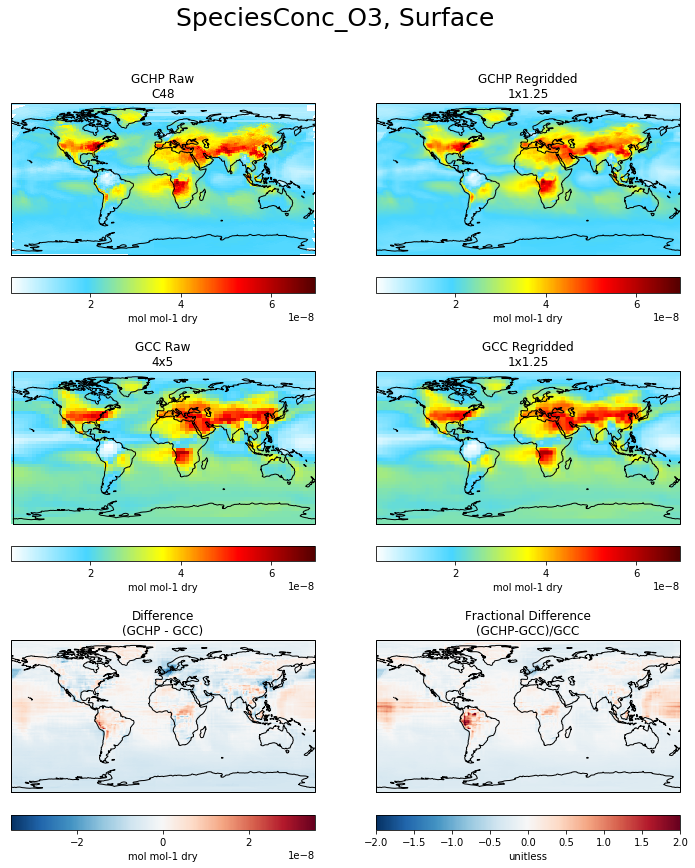

In [22]:
compare_level_maps(ds1, ds2, varlist=[varname], weightsdir=weightsdir)

## Define function to plot and compare zonal means of GCHP and GCC

Note: Zonal mean is defined as the mean value across a constant latitudinal band. Calculating zonal mean from cubed sphere is not straight-forward. Regridding to lat/lon makes more sense.

In [23]:
def compare_zonal_maps(dgcc, dgchp, varlist=None, weightsdir='.', itime=0, llres_raw='4x5', 
                       llres_cmp='1x1.25', savepdf=False, pdfname='gchp_vs_gcc_map.pdf', match_cbar=True, 
                       full_ratio_range=False, normalize_by_area=False, area1=None, area2=None):

    # If no varlist is passed, plot all 3D variables in the dataset
    if varlist == None:
        [commonvars, commonvars2D, varlist] = compare_varnames(dgcc, dgchp)
        print('Plotting all 3D variables')
    n_var = len(varlist)
    
    # Get lat-lon grids and regridder. Assume regridding weights have already been generated
    llgrid_raw = make_grid_LL(llres_raw)
    llgrid_cmp = make_grid_LL(llres_cmp)
    ll_regridder = make_regridder_L2L(llres_raw, llres_cmp, weightsdir=weightsdir, reuse_weights=True)

    # Get cubed sphere grid and regridder
    csres = dgchp['lon'].size
    [csgrid, csgrid_list] = make_grid_CS(csres)
    cs_regridder_list = make_regridder_C2L(csres, llres_cmp, weightsdir=weightsdir, reuse_weights=True)
    
    # Universal plot setup
    xtick_positions = np.arange(-90,91,30)
    xticklabels = ['{}$\degree$'.format(x) for x in xtick_positions]
    ytick_positions = np.arange(0,61,20)
    yticklabels = [str(y) for y in ytick_positions]
    
    # Create pdf (if saving)
    if savepdf:
        print('\nCreating {}'.format(pdfname))
        pdf = PdfPages(pdfname)

    # Loop over variables
    for ivar in range(n_var):
        if savepdf: print('{} '.format(ivar), end='')
        varname = varlist[ivar]
        
        # Do some checks: dimensions and units
        varndim = dgchp[varname].ndim
        varndim2 = dgcc[varname].ndim
        if 'ilev' in dgcc[varname].dims: nlev = 73
        else: nlev = 72
        assert varndim == varndim2, 'GCHP and GCC dimensions do not agree for {}!'.format(varname)
        units_raw = dgchp[varname].units
        units2 = dgcc[varname].units
        assert units_raw == units2, 'GCHP and GCC units do not match for {}!'.format(varname)
        
        # Set plot extent
        extent=(-90,90,0,nlev)
        
        # if normalizing by area, adjust units to be per m2, and adjust title string
        units = units_raw
        subtitle_extra = ''
        
        # Fix units for WetLossLS (placeholder in v11-02e)
        if 'WetLossLS' in varname: units_raw = 'kg s-1'
        
        # Slice the data
        ds1 = dgcc[varname].isel(time=itime)
        ds2 = dgchp[varname].isel(time=itime)

        # if normalizing by area, transform on the native grid and adjust units and subtitle string
        exclude_list = ['WetLossConvFrac','Prod_','Loss_']
        if normalize_by_area and not any(s in varname for s in exclude_list):
            ds1.values = ds1.values / area1.values[np.newaxis,:,:]
            ds2.values = ds2.values / area2.values[np.newaxis,:,:]
            units = '{} m-2'.format(units_raw)
            subtitle_extra = ', Normalized by Area'
            
        # Regrid the slices
        csdata = ds2.data.reshape(nlev,6,csres,csres).swapaxes(0,1)
        gchp_ll = np.zeros([nlev, llgrid_cmp['lat'].size, llgrid_cmp['lon'].size])
        for i in range(6):
            regridder = cs_regridder_list[i]
            gchp_ll += regridder(csdata[i])
        gcc_ll = ll_regridder(ds1)
        
        # Calculate zonal mean of the regridded data
        gchp_zm = gchp_ll.mean(axis=1)
        gcc_zm = gcc_ll.mean(axis=1)
            
        # Get min and max for colorbar limits
        [vmin_gchp, vmax_gchp] = [gchp_zm.min(), gchp_zm.max()]
        [vmin_gcc, vmax_gcc] = [gcc_zm.min(), gcc_zm.max()]
        vmin_cmn = np.min([vmin_gchp, vmin_gcc])
        vmax_cmn = np.max([vmax_gchp, vmax_gcc])
        if match_cbar: [vmin, vmax] = [vmin_cmn, vmax_cmn]
        
        # Create 2x2 figure
        figs, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=[12,12], 
                                                      subplot_kw={'projection': crs.PlateCarree()})
        # Give the page a title
        offset = 0.96
        fontsize=25
        figs.suptitle('{}, Zonal Mean'.format(varname), fontsize=fontsize, y=offset)

        # Subplot 0: GCHP regridded
        if not match_cbar: [vmin, vmax] = [vmin_gchp, vmax_gchp]
        plot0 = ax0.imshow(gchp_zm, cmap=WhGrYlRd, extent=extent, vmin=vmin, vmax=vmax)
        ax0.set_title('GCHP Regridded{}\n{}'.format(subtitle_extra, llres_cmp))
        ax0.set_aspect('auto')
        ax0.set_xticks(xtick_positions)
        ax0.set_xticklabels(xticklabels)
        ax0.set_yticks(ytick_positions)
        ax0.set_yticklabels(yticklabels)
        cb = plt.colorbar(plot0, ax=ax0, orientation='horizontal', pad=0.10)
        if (vmax-vmin) < 0.001 or (vmax-vmin) > 1000:
            cb.locator = ticker.MaxNLocator(nbins=4)
            cb.update_ticks()
        cb.set_label(units)
        
        # Subplot 1: GCC regridded
        if not match_cbar: [vmin, vmax] = [vmin_gcc, vmax_gcc]
        plot1 = ax1.imshow(gcc_zm, cmap=WhGrYlRd, extent=extent, vmin=vmin, vmax=vmax)
        ax1.set_title('GCC Regridded{}\n{}'.format(subtitle_extra, llres_cmp))
        ax1.set_aspect('auto')
        ax1.set_xticks(xtick_positions)
        ax1.set_xticklabels(xticklabels)
        ax1.set_yticks(ytick_positions)
        ax1.set_yticklabels(yticklabels)
        cb = plt.colorbar(plot1, ax=ax1, orientation='horizontal', pad=0.10)
        if (vmax-vmin) < 0.001 or (vmax-vmin) > 1000:
            cb.locator = ticker.MaxNLocator(nbins=4)
            cb.update_ticks()
        cb.set_label(units)
            
        # Subplot 2: Difference
        gc_absdiff = gchp_zm - gcc_zm
        diffabsmax = max([np.abs(gc_absdiff.min()), np.abs(gc_absdiff.max())])
        [vmin, vmax] = [-diffabsmax, diffabsmax]
        plot2 = ax2.imshow(gc_absdiff, cmap='RdBu_r', extent=extent, vmin=vmin, vmax=vmax)
        ax2.set_title('Difference\n(GCHP - GCC)')
        ax2.set_aspect('auto')
        ax2.set_xticks(xtick_positions)
        ax2.set_xticklabels(xticklabels)
        ax2.set_yticks(ytick_positions)
        ax2.set_yticklabels(yticklabels)
        cb = plt.colorbar(plot2, ax=ax2, orientation='horizontal', pad=0.10)
        if (vmax-vmin) < 0.001 or (vmax-vmin) > 1000:
            cb.locator = ticker.MaxNLocator(nbins=4)
            cb.update_ticks()
        cb.set_label(units)
        
        # Subplot 3: Fractional Difference (restrict to +/-2)
        gc_fracdiff = (gchp_zm - gcc_zm) / gcc_zm
        if full_ratio_range: [vmin, vmax] = [None, None]
        else: [vmin, vmax] = [-2, 2]
        plot3 = ax3.imshow(gc_fracdiff, vmin=vmin, vmax=vmax, cmap='RdBu_r', extent=extent)
        ax3.set_title('Fractional Difference\n(GCHP-GCC)/GCC')
        ax3.set_aspect('auto')
        ax3.set_xticks(xtick_positions)
        ax3.set_xticklabels(xticklabels)
        ax3.set_yticks(ytick_positions)
        ax3.set_yticklabels(yticklabels)
        cb = plt.colorbar(plot3, ax=ax3, orientation='horizontal', pad=0.10)
        cb.set_clim(vmin=vmin, vmax=vmax)
        cb.set_label('unitless')      
            
        if savepdf:    
            pdf.savefig(figs)
            plt.close(figs)
            
    if savepdf: pdf.close()

### Plot zonal mean: regridded data, difference, and fractional difference

Reuse existing file: ./conservative_4x5_1x1.25.nc
Reuse existing file: ./conservative_c48_1x1.25_0.nc
Reuse existing file: ./conservative_c48_1x1.25_1.nc
Reuse existing file: ./conservative_c48_1x1.25_2.nc
Reuse existing file: ./conservative_c48_1x1.25_3.nc
Reuse existing file: ./conservative_c48_1x1.25_4.nc
Reuse existing file: ./conservative_c48_1x1.25_5.nc


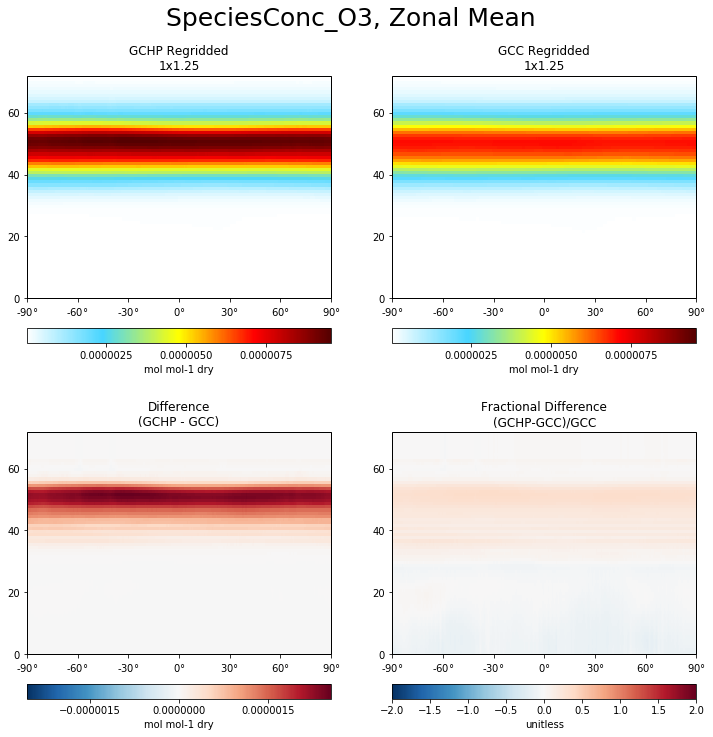

In [24]:
compare_zonal_maps(ds1, ds2, varlist=[varname], weightsdir=weightsdir )

## Handling Diagnostics with Area-dependent Units

### Store Grid Areas for Normalizing by Area

In [25]:
collection = 'StateMet'
areavar='Met_AREAM2'
f1_a = get_gcc_filepath(datadir, f1datadir, collection, f1day, f1time)
f2_a = get_gchp_filepath(datadir, f2datadir, collection, f2day, f2time)
ds1_a = xr.open_dataset(f1_a)
ds2_a = xr.open_dataset(f2_a)
area1 = ds1_a['Met_AREAM2'].isel(lev=0,time=0)
area2 = ds2_a['Met_AREAM2'].isel(lev=0,time=0)
print('GCC native grid area array shape: {}'.format(area1.shape))
print('GCHP native grid area array shape: {}'.format(area2.shape))

GCC data path: /home/ubuntu/csci_e29/project/data/gcc/GEOSChem.StateMet.20160701_0000z.nc4
GCHP data path: /home/ubuntu/csci_e29/project/data/gchp/GCHP.StateMet.20160716_1200z.nc4
GCC native grid area array shape: (46, 72)
GCHP native grid area array shape: (288, 48)


### Plot an area-dependent variable without normalizing by area to see the issue

GCC data path: /home/ubuntu/csci_e29/project/data/gcc/GEOSChem.WetLossConv.20160701_0000z.nc4
GCHP data path: /home/ubuntu/csci_e29/project/data/gchp/GCHP.WetLossConv.20160716_1200z.nc4
Reuse existing file: ./conservative_4x5_1x1.25.nc
Reuse existing file: ./conservative_c48_1x1.25_0.nc
Reuse existing file: ./conservative_c48_1x1.25_1.nc
Reuse existing file: ./conservative_c48_1x1.25_2.nc
Reuse existing file: ./conservative_c48_1x1.25_3.nc
Reuse existing file: ./conservative_c48_1x1.25_4.nc
Reuse existing file: ./conservative_c48_1x1.25_5.nc


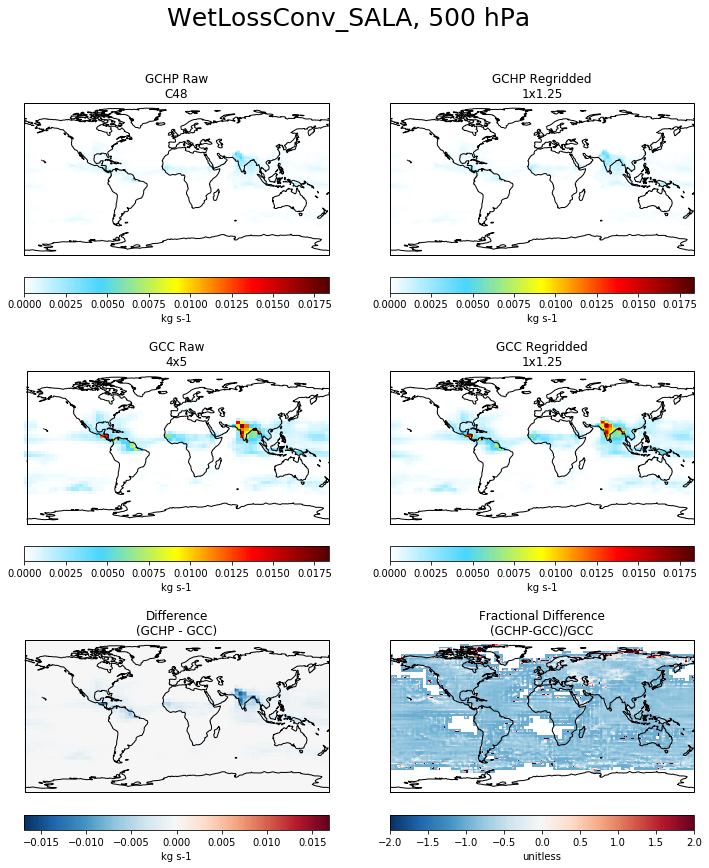

In [26]:
collection = 'WetLossConv'
f1 = get_gcc_filepath(datadir, f1datadir, collection, f1day, f1time)
f2 = get_gchp_filepath(datadir, f2datadir, collection, f2day, f2time)
ds1 = xr.open_dataset(f1)
ds2 = xr.open_dataset(f2)
varname = 'WetLossConv_SALA'
compare_level_maps(ds1, ds2, varlist=[varname], ilev=22, weightsdir=weightsdir)

### Plot the same variable again but this time normalize by area

Reuse existing file: ./conservative_4x5_1x1.25.nc
Reuse existing file: ./conservative_c48_1x1.25_0.nc
Reuse existing file: ./conservative_c48_1x1.25_1.nc
Reuse existing file: ./conservative_c48_1x1.25_2.nc
Reuse existing file: ./conservative_c48_1x1.25_3.nc
Reuse existing file: ./conservative_c48_1x1.25_4.nc
Reuse existing file: ./conservative_c48_1x1.25_5.nc


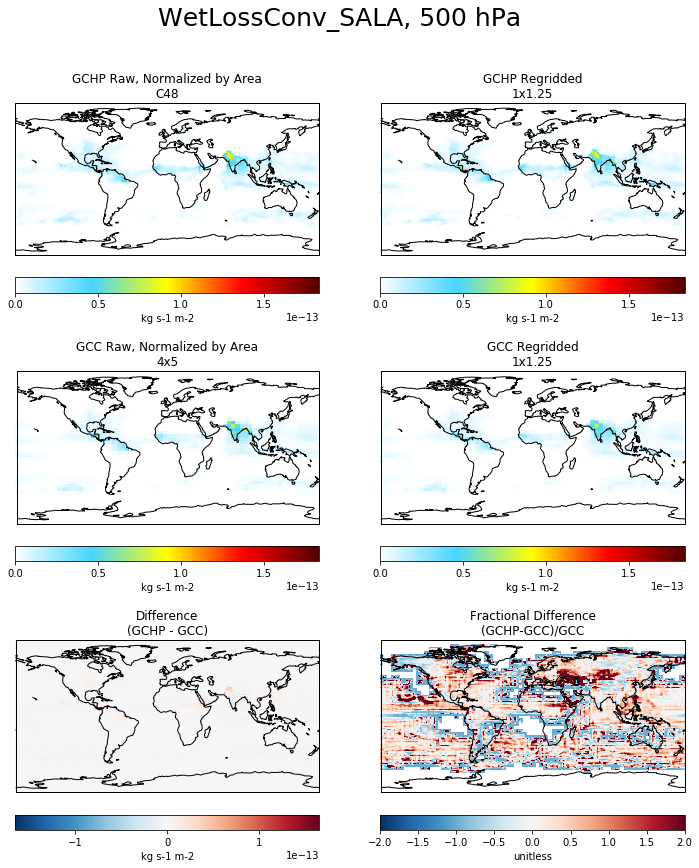

In [27]:
compare_level_maps(ds1, ds2, varlist=[varname], ilev=22, weightsdir=weightsdir, normalize_by_area=True, area1=area1, area2=area2)

## Save a subset of collection variables to a pdf

### Define directory to save plots (must already exist)

In [28]:
plotsdir = os.path.join('.')

### Choose a collection and look at common variables

In [29]:
collection = 'Aerosols'
f1 = get_gcc_filepath(datadir, f1datadir, collection, f1day, f1time)
f2 = get_gchp_filepath(datadir, f2datadir, collection, f2day, f2time)
ds1 = xr.open_dataset(f1)
ds2 = xr.open_dataset(f2)
[commonvars, commonvars2D, commonvars3D] = compare_varnames(ds1, ds2)
commonvars3D

GCC data path: /home/ubuntu/csci_e29/project/data/gcc/GEOSChem.Aerosols.20160701_0000z.nc4
GCHP data path: /home/ubuntu/csci_e29/project/data/gchp/GCHP.Aerosols.20160716_1200z.nc4
85 common variables (0 are 2-dim and 85 are 3-dim)
21 variables in gcc only (skip)
   Variable names: ['hyam', 'hybm', 'hyai', 'hybi', 'P0', 'AREA', 'AODPolarStratCloud550nm', 'AODStratLiquidAer550nm', 'AODSOAfromAqIsoprene550nm', 'AODHyg550nm_SALC', 'AODHyg550nm_SALA', 'AODHyg550nm_OCPI', 'AODHyg550nm_BCPI', 'AODHyg550nm_SO4', 'AODDust550nm_bin7', 'AODDust550nm_bin6', 'AODDust550nm_bin5', 'AODDust550nm_bin4', 'AODDust550nm_bin3', 'AODDust550nm_bin2', 'AODDust550nm_bin1']
15 variables in gchp only (skip)
   Variable names: ['AODDustWL1_bin1', 'AODDustWL1_bin2', 'AODDustWL1_bin3', 'AODDustWL1_bin4', 'AODDustWL1_bin5', 'AODDustWL1_bin6', 'AODDustWL1_bin7', 'AODHygWL1_BCPI', 'AODHygWL1_OCPI', 'AODHygWL1_SALA', 'AODHygWL1_SALC', 'AODHygWL1_SO4', 'AODPolarStratCloudWL1', 'AODSOAfromAqIsopreneWL1', 'AODStratLiquidA

['AODDust',
 'AerAqueousVolume',
 'AerHygroscopicGrowth_BCPI',
 'AerHygroscopicGrowth_OCPI',
 'AerHygroscopicGrowth_SALA',
 'AerHygroscopicGrowth_SALC',
 'AerHygroscopicGrowth_SO4',
 'AerNumDensityStratLiquid',
 'AerNumDensityStratParticulate',
 'AerSurfAreaDust',
 'AerSurfAreaHyg_BCPI',
 'AerSurfAreaHyg_OCPI',
 'AerSurfAreaHyg_SALA',
 'AerSurfAreaHyg_SALC',
 'AerSurfAreaHyg_SO4',
 'AerSurfAreaPolarStratCloud',
 'AerSurfAreaStratLiquid',
 'Chem_AeroAreaBC',
 'Chem_AeroAreaBGSULF',
 'Chem_AeroAreaICEI',
 'Chem_AeroAreaMDUST1',
 'Chem_AeroAreaMDUST2',
 'Chem_AeroAreaMDUST3',
 'Chem_AeroAreaMDUST4',
 'Chem_AeroAreaMDUST5',
 'Chem_AeroAreaMDUST6',
 'Chem_AeroAreaMDUST7',
 'Chem_AeroAreaOC',
 'Chem_AeroAreaSSA',
 'Chem_AeroAreaSSC',
 'Chem_AeroAreaSULF',
 'Chem_AeroRadiBC',
 'Chem_AeroRadiBGSULF',
 'Chem_AeroRadiICEI',
 'Chem_AeroRadiMDUST1',
 'Chem_AeroRadiMDUST2',
 'Chem_AeroRadiMDUST3',
 'Chem_AeroRadiMDUST4',
 'Chem_AeroRadiMDUST5',
 'Chem_AeroRadiMDUST6',
 'Chem_AeroRadiMDUST7',
 'Chem

### For this example, only plot the aerosol hygroscopic growth diagnostics

In [30]:
varlist=[k for k in commonvars3D if 'AerHygroscopic' in k]
varlist

['AerHygroscopicGrowth_BCPI',
 'AerHygroscopicGrowth_OCPI',
 'AerHygroscopicGrowth_SALA',
 'AerHygroscopicGrowth_SALC',
 'AerHygroscopicGrowth_SO4']

In [31]:
ilev=22
pdfname = os.path.join(plotsdir,'{}_HygroscopicGrowth_L{}.pdf'.format(collection, ilev))
compare_level_maps(ds1, ds2, varlist=varlist, ilev=ilev, weightsdir=weightsdir, savepdf=True, pdfname=pdfname )

Reuse existing file: ./conservative_4x5_1x1.25.nc
Reuse existing file: ./conservative_c48_1x1.25_0.nc
Reuse existing file: ./conservative_c48_1x1.25_1.nc
Reuse existing file: ./conservative_c48_1x1.25_2.nc
Reuse existing file: ./conservative_c48_1x1.25_3.nc
Reuse existing file: ./conservative_c48_1x1.25_4.nc
Reuse existing file: ./conservative_c48_1x1.25_5.nc

Creating ./Aerosols_HygroscopicGrowth_L22.pdf
0 1 2 3 4 